In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [4]:
import os
import sys
import json

import numpy as np
import tensorflow as tf

from data0_utils import *

config_file = './config/letor07_mp_fold1.model'
config = json.loads(open(model_file).read())
Letor07Path = config['data_dir']

du = DataLoader(config_file)
config['fill_word'] = du._PAD_
config['embedding'] = du.embedding
config['feat_size'] = du.feat_size

[./data//word_dict.txt]
	Word dict size: 193367
[./data//qid_query.txt]
	Data size: 1692
[./data//docid_doc.txt]
	Data size: 65323
[./data//embed_wiki-pdc_d50_norm]
	Embedding size: 109282
Generate numpy embed: (193368, 50)


In [5]:
list_gen = ListGenerator(rel_file=Letor07Path + '/relation.test.fold%d.txt'%(config['fold']), config=config)

[./data//relation.test.fold1.txt]
	Instance size: 13652
List Instance Count: 336


In [6]:
def dynamic_pooling_index(len1, len2, max_len1, max_len2,
                          compress_ratio1 = 1, compress_ratio2 = 1):
    def dpool_index_(batch_idx, len1_one, len2_one, max_len1, max_len2):
        if len1_one == 0:
            stride1 = max_len1
        else:
            stride1 = 1.0 * max_len1 / len1_one

        if len2_one == 0:
            stride2 = max_len2
        else:
            stride2 = 1.0 * max_len2 / len2_one

        idx1_one = [int(i / stride1) for i in range(max_len1)]
        idx2_one = [int(i / stride2) for i in range(max_len2)]
        mesh1, mesh2 = np.meshgrid(idx1_one, idx2_one)
        index_one = np.transpose(np.stack([np.ones(mesh1.shape) * batch_idx,
                                  mesh1, mesh2]), (2,1,0))
        return index_one
    index = []
    dpool_bias1 = dpool_bias2 = 0
    if max_len1 % compress_ratio1 != 0:
        dpool_bias1 = 1
    if max_len2 % compress_ratio2 != 0:
        dpool_bias2 = 1
    cur_max_len1 = max_len1 // compress_ratio1 + dpool_bias1
    cur_max_len2 = max_len2 // compress_ratio2 + dpool_bias2
    for i in range(len(len1)):
        index.append(dpool_index_(i, len1[i] // compress_ratio1,
                     len2[i] // compress_ratio2, cur_max_len1, cur_max_len2))
    return np.array(index)

In [8]:
saver = tf.train.import_meta_graph('./checkpoint/letor07_mp_fold1.meta')
print(tf.get_collection('explain_input'))
print(tf.get_collection('explain_output'))
placeholders = {op.name:op.values() for op in tf.get_default_graph().get_operations() if op.type == "Placeholder"}
print(placeholders)

[<tf.Tensor 'embedding_lookup:0' shape=(?, 20, 50) dtype=float32>, <tf.Tensor 'embedding_lookup_1:0' shape=(?, 500, 50) dtype=float32>, <tf.Tensor 'einsum/transpose_2:0' shape=(?, 20, 500) dtype=float32>]
[<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, 1) dtype=float32>]
{'X1': (<tf.Tensor 'X1:0' shape=(?, 20) dtype=int32>,), 'X2': (<tf.Tensor 'X2:0' shape=(?, 500) dtype=int32>,), 'X1_len': (<tf.Tensor 'X1_len:0' shape=(?,) dtype=int32>,), 'X2_len': (<tf.Tensor 'X2_len:0' shape=(?,) dtype=int32>,), 'Y': (<tf.Tensor 'Y:0' shape=(?,) dtype=int32>,), 'F': (<tf.Tensor 'F:0' shape=(?, 0) dtype=float32>,), 'dpool_index': (<tf.Tensor 'dpool_index:0' shape=(?, 20, 500, 3) dtype=int32>,)}


In [9]:
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(config=sess_config)
saver.restore(sess=sess, save_path='./checkpoint/letor07_mp_fold1.ckpt-1599')
grads1 = tf.gradients(ys=tf.get_collection('explain_output')[0], xs=tf.get_collection('explain_input')[0])
grads2 = tf.gradients(ys=tf.get_collection('explain_output')[0], xs=tf.get_collection('explain_input')[1])

INFO:tensorflow:Restoring parameters from ./checkpoint/letor07_mp_fold1.ckpt-1599


In [120]:
def linearly_interpolate(sample, reference=False, num_steps=50):
    # Use default reference values if reference is not specified
    if reference is False: reference = np.zeros(sample.shape);

    # Reference and sample shape needs to match exactly
    assert sample.shape == reference.shape

    # Calcuated stepwise difference from reference to the actual sample.
    ret = np.zeros(tuple([num_steps] +[i for i in sample.shape]))
    step = (sample - reference) * (1.0 / num_steps)
    for s in range(num_steps):
        ret[s] = reference + s * step

    return ret, num_steps, step

In [145]:
def linearly_interpolate_word(sample, reference=False, num_steps=50):
    # Use default reference values if reference is not specified
    if reference is False: reference = np.zeros(sample.shape);

    # Reference and sample shape needs to match exactly
    assert sample.shape == reference.shape

    # Calcuated stepwise difference from reference to the actual sample.
    ret = np.zeros(tuple([num_steps] +[i for i in sample.shape]))
    step = (sample - reference) * (1.0 / num_steps)
    ret[0] = np.copy(reference)
    idx_step = sample.shape[1] / num_steps
    for s in range(0, num_steps-1):
        ret[s+1] = np.copy(ret[s])
        ret[s+1][:,int(s*idx_step):int((s+1)*idx_step),:] = sample[:,int(s*idx_step):int((s+1)*idx_step),:]
    ret[num_steps-1] = np.copy(sample)

    return ret, num_steps, step

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
import numpy.linalg as LA

def get_text_val(seq, mapper, exp_mat):
    exp_val = []
    for v in exp_mat:
        #exp_val.append(LA.norm(v, 1))
        exp_val.append(np.sum(v))
    text = [mapper[x] for x in seq]
    for i in range(len(text)):
        if text[i] == '$$':
            text[i] = '[EOS]'
    return text, exp_val

def visualize_explain(seq, mapper, exp_mat):
    text, exp_val = get_text_val(seq, mapper, exp_mat)
    zhfont1 = fm.FontProperties(fname='/home/pangliang/font/simhei.ttf', size=12)
    fig, ax = plt.subplots(figsize=[len(text) * 0.7, 0.7])
    E = np.array([exp_val,])
    ax.pcolor(np.ma.array(E,mask=(E<=0)), cmap=plt.cm.Reds)
    ax.pcolor(np.ma.array(E,mask=(E>=0)), cmap=plt.cm.Blues_r)
    ax.set_xticks(np.array(range(len(text)))+0.5)
    ax.set_xticklabels(text, rotation=45, fontproperties=zhfont1)

In [177]:
import matplotlib.pyplot as plt
from matplotlib import cm, transforms
%matplotlib inline

# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    for i in range(len(words)):
        if words[i] == '$$':
            words[i] = '[EOS]'
            
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [212]:
def explain(X1, X2, X1_len, X2_len, Y, config):
    DPool = dynamic_pooling_index(X1_len, X2_len, config['data1_maxlen'], config['data2_maxlen'])
    I1, I2, I3 = sess.run(tf.get_collection('explain_input'), feed_dict={
        placeholders['X1']: X1,
        placeholders['X2']: X2,
        placeholders['dpool_index']: DPool
                           })
    
    I1_ref, I2_ref, I3_ref = sess.run(tf.get_collection('explain_input'), feed_dict={
        placeholders['X1']: np.ones_like(X1) * du._PAD_,
        placeholders['X2']: np.ones_like(X2) * du._PAD_,
        placeholders['dpool_index']: DPool
                       })
    
    X1_dup = np.repeat(X1, axis=0, repeats=50)
    X1_len_dup = np.repeat(X1_len, axis=0, repeats=50)
    X2_dup = np.repeat(X2, axis=0, repeats=50)
    X2_len_dup = np.repeat(X2_len, axis=0, repeats=50)
    DPool_dup = dynamic_pooling_index(
        X1_len_dup, 
        X2_len_dup, 
        config['data1_maxlen'], 
        config['data2_maxlen'])
    
    #inter1, num_step1, step_size1 = linearly_interpolate(I1, I1_ref)
    #inter2, num_step2, step_size2 = linearly_interpolate(I2, I2_ref)
    
    inter1, num_step1, step_size1 = linearly_interpolate_word(I1, I1_ref)
    inter2, num_step2, step_size2 = linearly_interpolate_word(I2, I2_ref)
    
    score = sess.run(tf.get_collection('explain_output')[0], feed_dict={
        placeholders['X1']: X1,
        placeholders['X2']: X2,
        placeholders['dpool_index']: DPool
                           })
    print("Label = ", Y[0], ", Score = ", score[0])
    
    grad_1 = sess.run(grads1, feed_dict={
        placeholders['X2']: X2_dup,
        placeholders['dpool_index']: DPool_dup,
        tf.get_collection('explain_input')[0]: inter1[:,0,:,:]
    })

    grad_2 = sess.run(grads2, feed_dict={
        placeholders['X1']: X1_dup,
        placeholders['dpool_index']: DPool_dup,
        tf.get_collection('explain_input')[1]: inter2[:,0,:,:]
    })

    v1 = np.sum(grad_1[0]*step_size1[0], axis=0)
    #visualize_explain(X1[0], du.word_dict, v1)
    #plt.show()
    plot_text_heatmap([du.word_dict[w] for w in X1[0]], np.mean(v1,axis=-1))
    #print(np.sum(v1, axis=1))

    v2 = np.sum(grad_2[0]*step_size2[0], axis=0)
    #visualize_explain(X2[0][-30:], du.word_dict, v2[-30:])
    #plt.show()
    #visualize_explain(X2[0], du.word_dict, v2)
    #plt.show()
    plot_text_heatmap([du.word_dict[w] for w in X2[0]], np.mean(v2,axis=-1))
    #print(np.sum(v2, axis=1)[:20])
    
    
    grad_two = sess.run([grads1, grads2], feed_dict={
        placeholders['dpool_index']: DPool_dup,
        tf.get_collection('explain_input')[0]: inter1[:,0,:,:],
        tf.get_collection('explain_input')[1]: inter2[:,0,:,:]
    })
    '''
    v1 = np.sum(grad_two[0][0]*step_size1[0], axis=0)
    visualize_explain(X1[0], du.word_dict, v1)
    plt.show()
    #print(np.sum(v1, axis=1))
    '''
    v2 = np.sum(grad_two[1][0]*step_size2[0], axis=0)
    #visualize_explain(X2[0][-30:], du.word_dict, v2[-30:])
    #plt.show()
    visualize_explain(X2[0], du.word_dict, v2)
    plt.show()
    #print(np.sum(v2, axis=1)[:20])
    

In [204]:
list_gen_obj = list_gen.get_batch(data1=du.query_data, data2=du.doc_data)

In [205]:
X1, X1_len, X2, X2_len, Y, F = next(list_gen_obj)

Label =  2 , Score =  [6.601853]


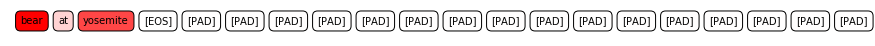

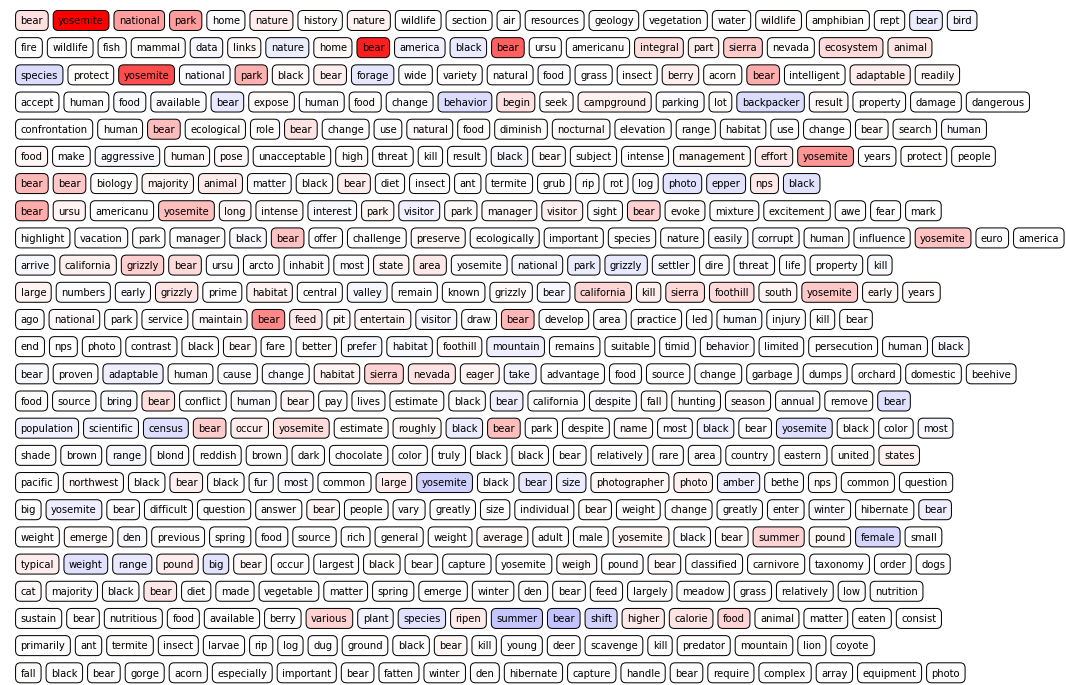

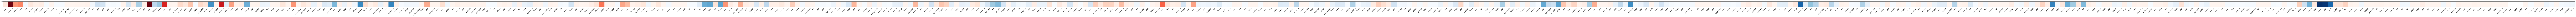

Label =  1 , Score =  [5.336222]


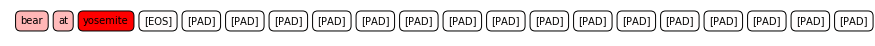

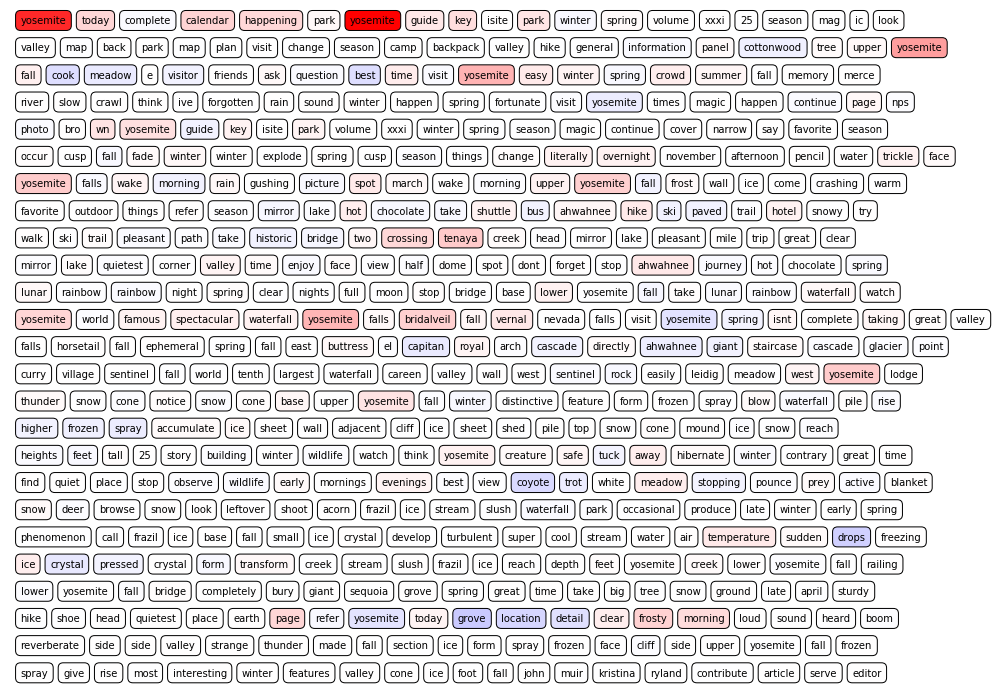

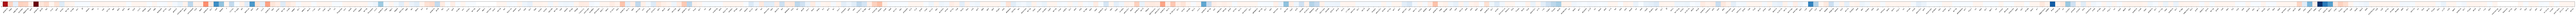

Label =  1 , Score =  [4.997845]


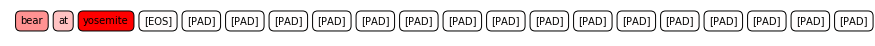

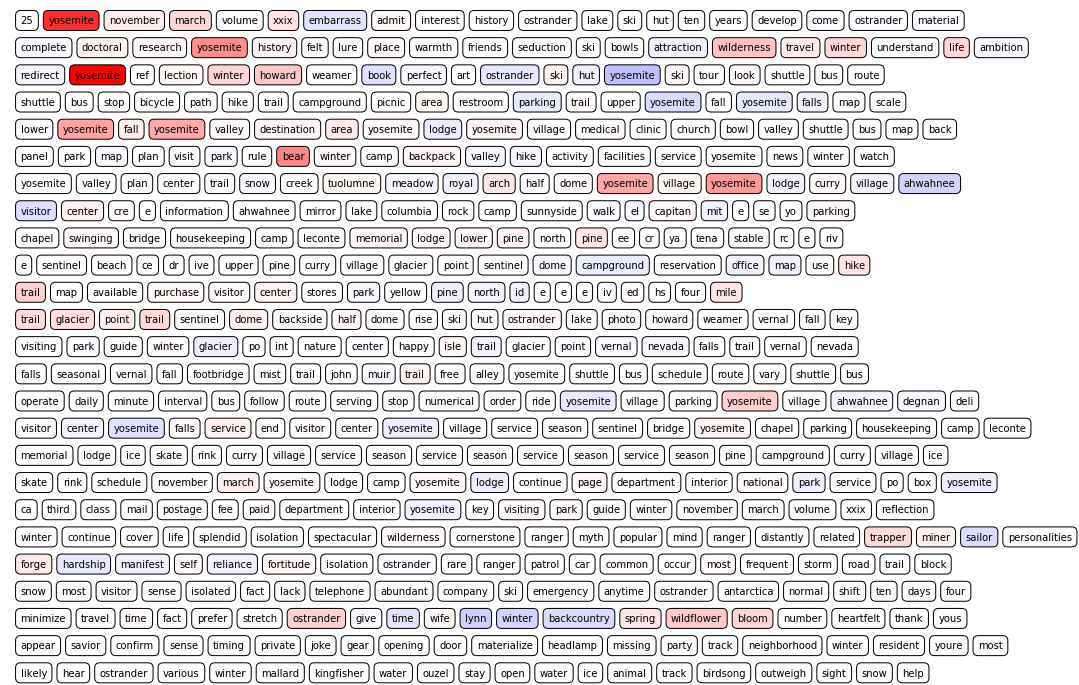

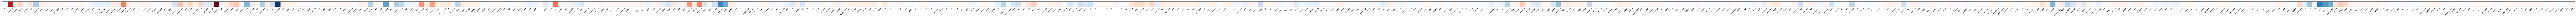

Label =  1 , Score =  [5.4986916]


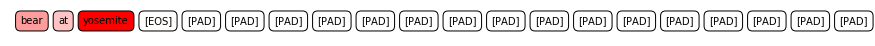

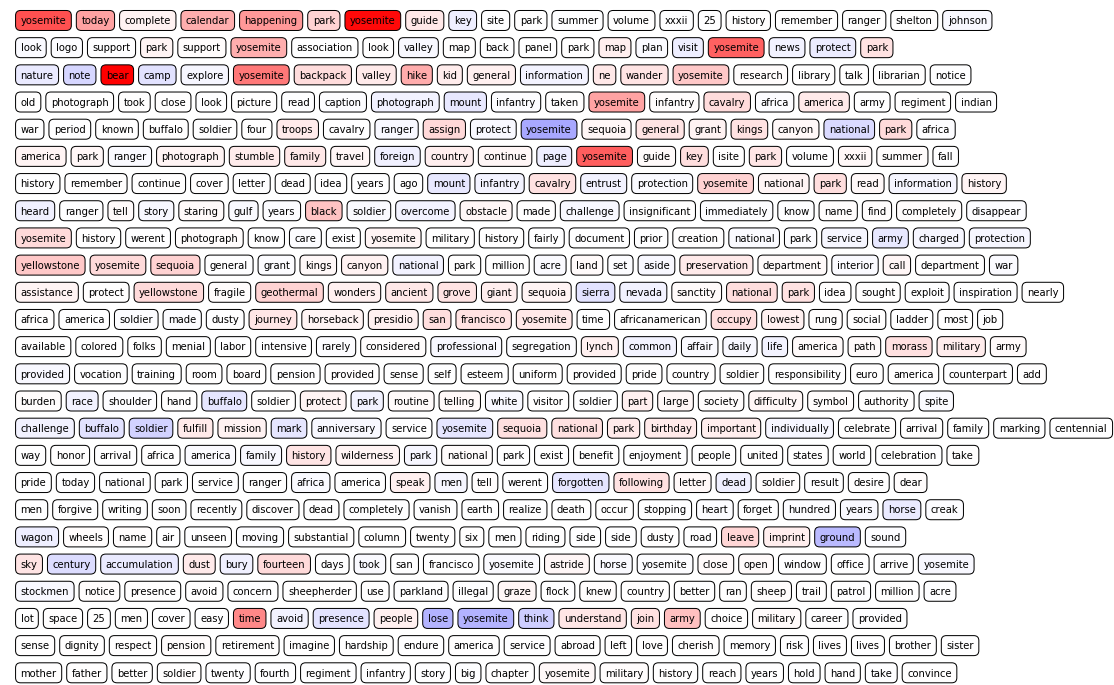

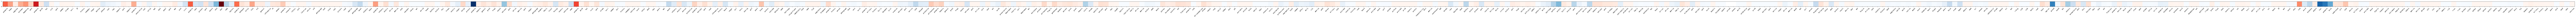

Label =  1 , Score =  [5.5180845]


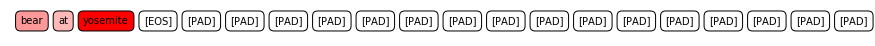

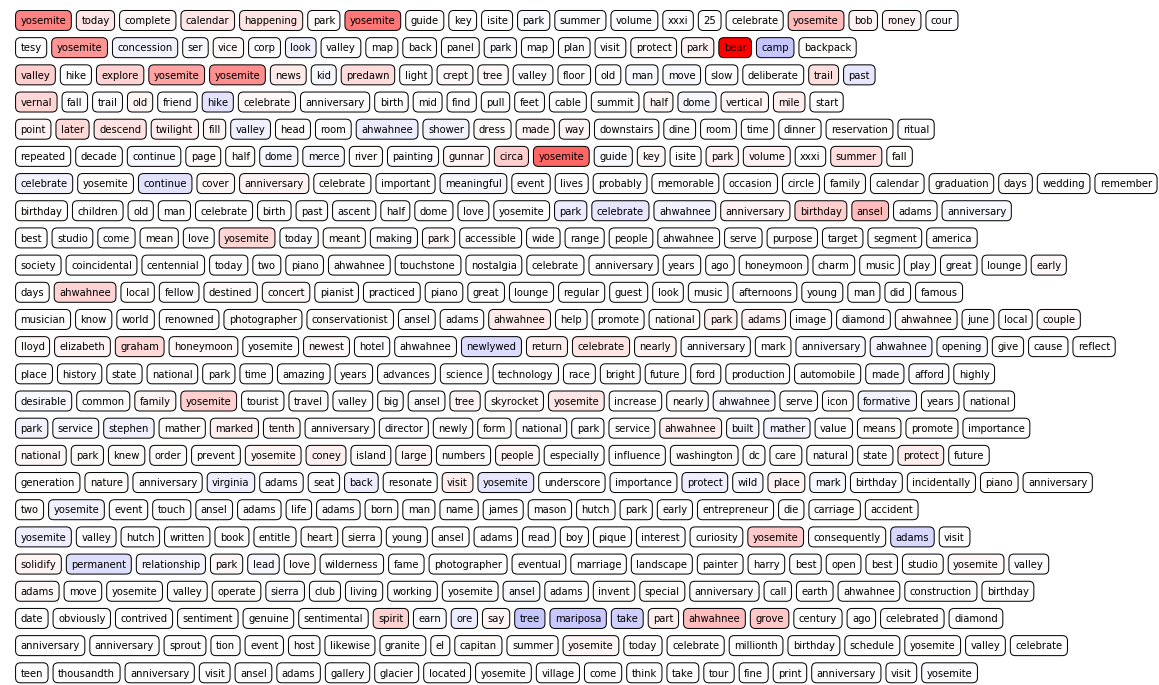

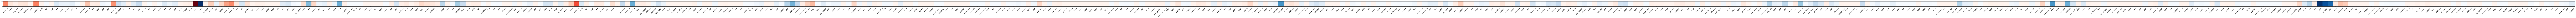

In [213]:
eid = 0
for eid in range(5):
    X1_one = X1[eid:eid+1]
    X1_len_one = X1_len[eid:eid+1]
    X2_one = X2[eid:eid+1]
    X2_len_one = X2_len[eid:eid+1]
    Y_one = Y[eid:eid+1]
    explain(X1_one, X2_one, X1_len_one, X2_len_one, Y_one, config)

Score =  [6.625708]


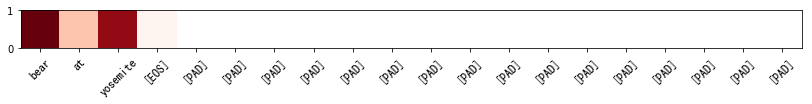

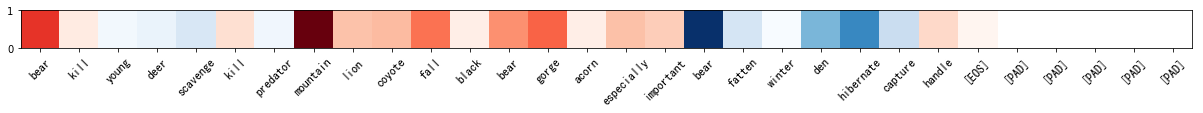

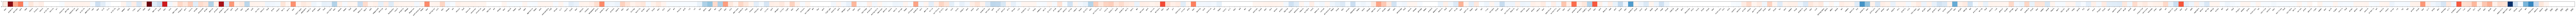

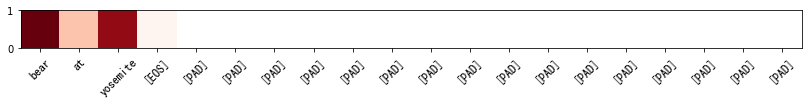

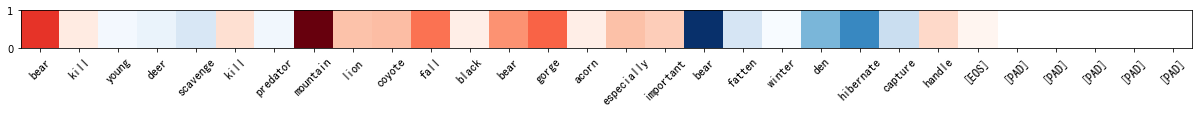

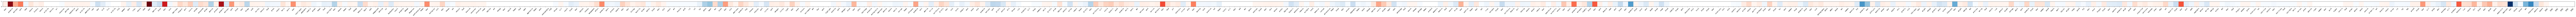

In [46]:
DEL_NUM = 6
X2_one_modi = np.copy(X2_one)
X2_one_modi[:,-DEL_NUM] = du.iword_dict['$$'] 
X2_one_modi[:,-DEL_NUM+1:] = du._PAD_
X2_len_one_modi = np.copy(X2_len_one)
X2_len_one_modi[0] -= (-DEL_NUM+1)
explain(X1_one, X2_one_modi, X1_len_one, X2_len_one_modi, config)

Score =  [4.6860704]


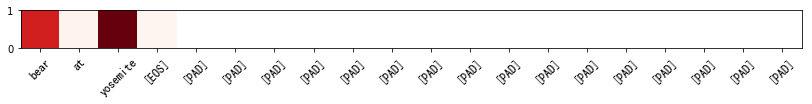

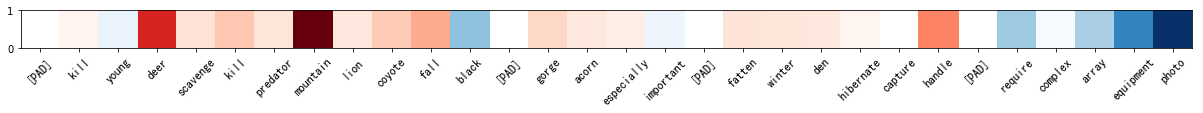

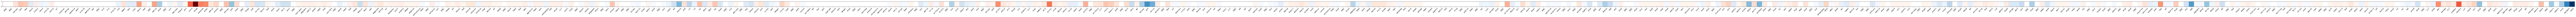

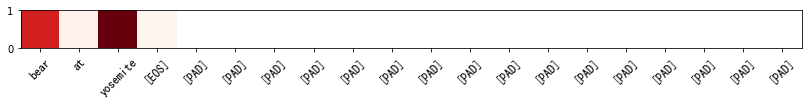

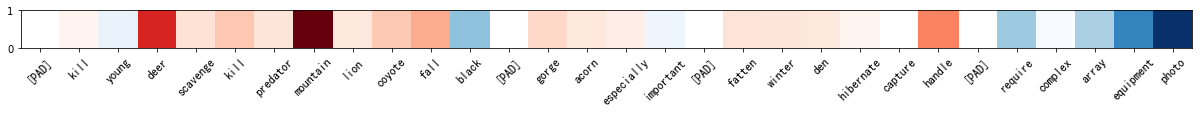

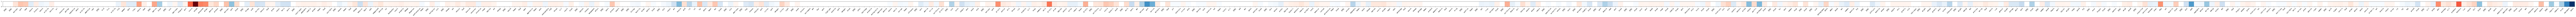

In [40]:
X2_one_modi = np.copy(X2_one)
X2_one_modi[X2_one_modi==du.iword_dict['bear']] = du._PAD_
X2_one_modi[X2_one_modi==du.iword_dict['yosemite']] = du._PAD_
explain(X1_one, X2_one_modi, X1_len_one, X2_len_one, config)

Score =  [8.149738]


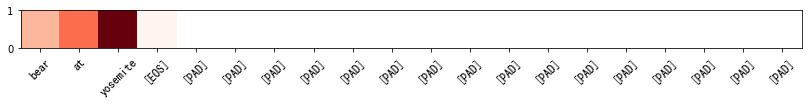

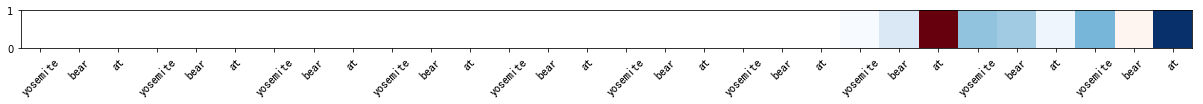

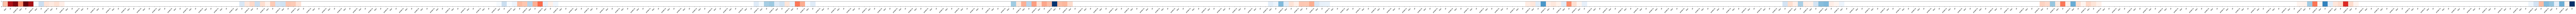

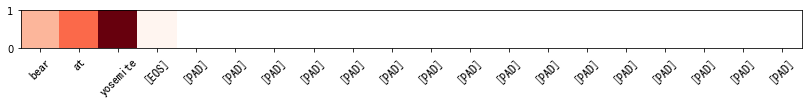

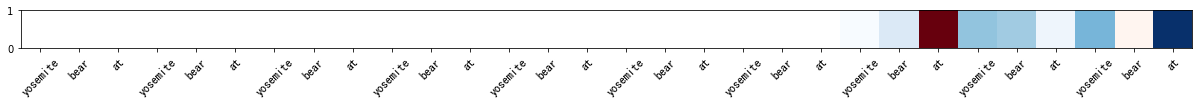

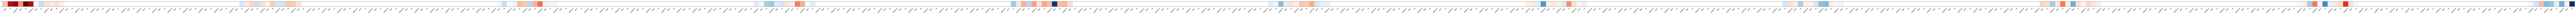

In [55]:
X2_one_modi = np.copy(X2_one)
X2_one_modi[:,::3] = du.iword_dict['bear']
X2_one_modi[:,1::3] = du.iword_dict['at']
X2_one_modi[:,2::3] = du.iword_dict['yosemite']
explain(X1_one, X2_one_modi, X1_len_one, X2_len_one, config)

Label =  2 , Score =  [-0.01313999]


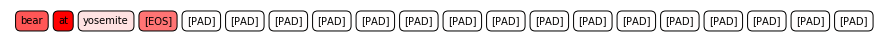

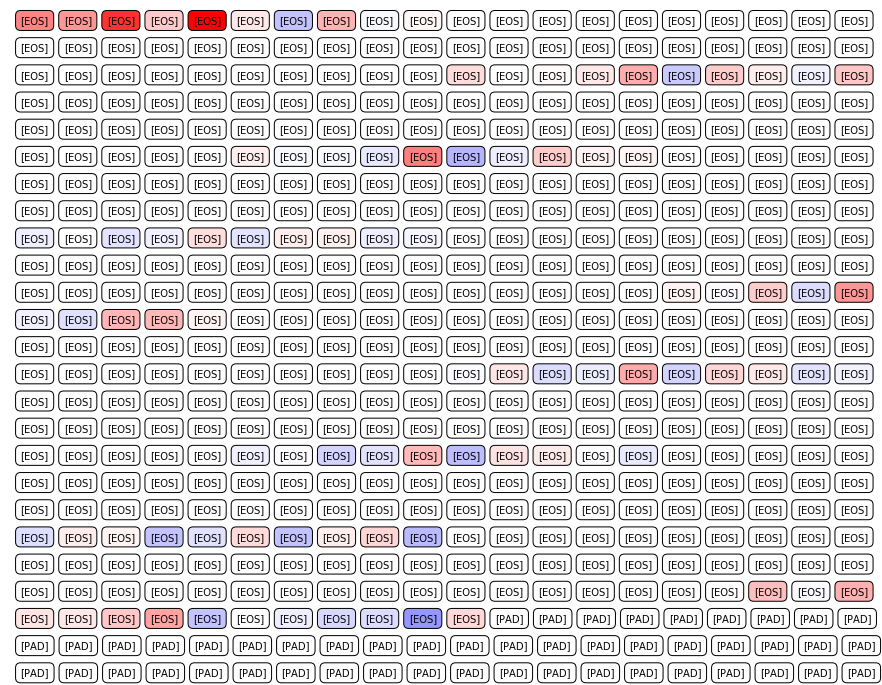

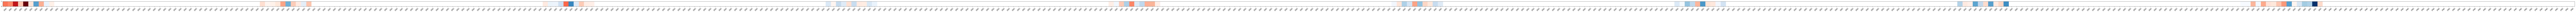

In [211]:
DEL_NUM = 50
X2_one_modi[:] = du.iword_dict['$$']
X2_one_modi[:,-DEL_NUM] = du.iword_dict['$$'] 
X2_one_modi[:,-DEL_NUM+1:] = du._PAD_
X2_len_one_modi = np.copy(X2_len_one)
X2_len_one_modi[0] -= (-DEL_NUM+1)
explain(X1_one, X2_one_modi, X1_len_one, X2_len_one_modi, Y_one, config)

Label =  2 , Score =  [-0.11421109]


/home/pangliang/nips/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


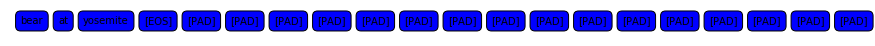

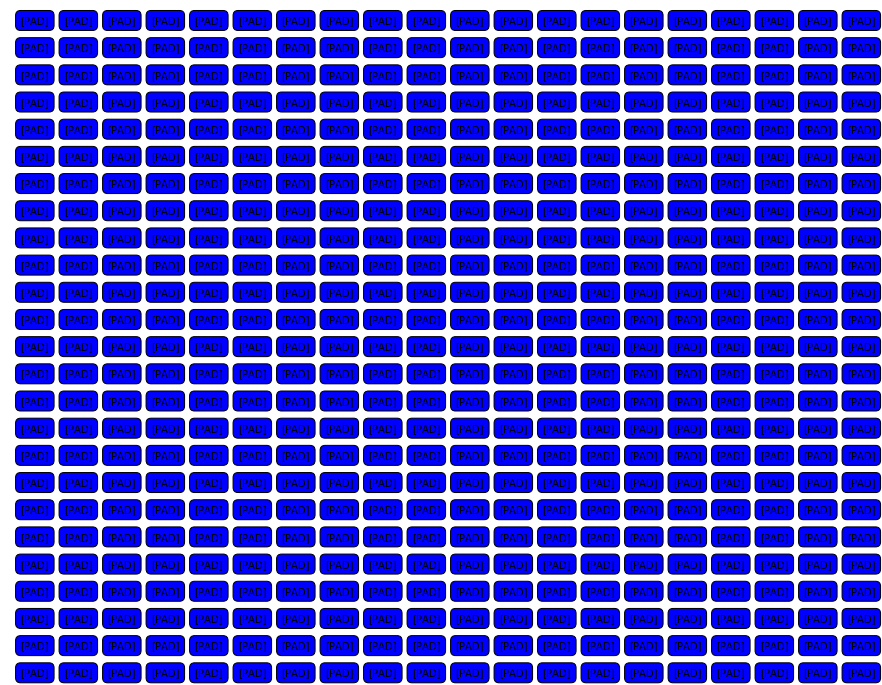

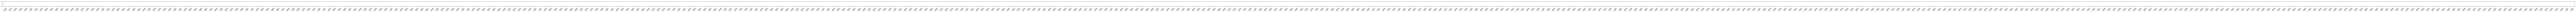

In [210]:
X2_one_modi[:] = du._PAD_
#X2_one_modi[:,:4] = du.iword_dict['bear'], du.iword_dict['at'], du.iword_dict['yosemite'], du.iword_dict['$$'] 
#X2_len_one_modi[0] = 4
explain(X1_one, X2_one_modi, X1_len_one, X2_len_one_modi, Y_one, config)

In [207]:
def pathIG(X1, X2, X1_len, X2_len, config):
    DPool = dynamic_pooling_index(X1_len, X2_len, config['data1_maxlen'], config['data2_maxlen'])
    I1, I2, I3 = sess.run(tf.get_collection('explain_input'), feed_dict={
        placeholders['X1']: X1,
        placeholders['X2']: X2,
        placeholders['dpool_index']: DPool
                           })
    
    I1_ref, I2_ref, I3_ref = sess.run(tf.get_collection('explain_input'), feed_dict={
        placeholders['X1']: np.ones_like(X1) * du._PAD_,
        placeholders['X2']: np.ones_like(X2) * du._PAD_,
        placeholders['dpool_index']: DPool
                       })
    
    X1_dup = np.repeat(X1, axis=0, repeats=50)
    X1_len_dup = np.repeat(X1_len, axis=0, repeats=50)
    X2_dup = np.repeat(X2, axis=0, repeats=50)
    X2_len_dup = np.repeat(X2_len, axis=0, repeats=50)
    DPool_dup = dynamic_pooling_index(
        X1_len_dup, 
        X2_len_dup, 
        config['data1_maxlen'], 
        config['data2_maxlen'])
    
    inter1, num_step1, step_size1 = linearly_interpolate(I1, I1_ref)
    inter2, num_step2, step_size2 = linearly_interpolate(I2, I2_ref)
    
    score = sess.run(tf.get_collection('explain_output')[0], feed_dict={
        tf.get_collection('explain_input')[0]: inter1[:,0,:,:],
        tf.get_collection('explain_input')[1]: inter2[:,0,:,:],
        placeholders['dpool_index']: DPool_dup
                           })
    plt.plot(score)
    plt.show()
    
    '''
    grad_1 = sess.run(grads1, feed_dict={
        placeholders['X2']: X2_dup,
        placeholders['dpool_index']: DPool_dup,
        tf.get_collection('explain_input')[0]: inter1[:,0,:,:]
    })

    grad_2 = sess.run(grads2, feed_dict={
        placeholders['X1']: X1_dup,
        placeholders['dpool_index']: DPool_dup,
        tf.get_collection('explain_input')[1]: inter2[:,0,:,:]
    })
    '''
    
    grad_two = sess.run([grads1, grads2], feed_dict={
        placeholders['dpool_index']: DPool_dup,
        tf.get_collection('explain_input')[0]: inter1[:,0,:,:],
        tf.get_collection('explain_input')[1]: inter2[:,0,:,:]
    })
    
    def norm_v(x):
        x = np.reshape(x, [x.shape[0],-1])
        x_min, x_max = np.min(x, axis=1), np.max(x, axis=1)
        x = ((x.T - x_min) / (x_max - x_min)).T
        x = np.mean(x, axis=1)
        return x
        
    v1 = norm_v(grad_two[0][0])
    v2 = norm_v(grad_two[1][0])
        
    #v1 = np.mean(grad_1[0], axis=1)
    #v1_min, v1_max = np.min(v1, axis=1), np.max(v1, axis=1)
    #v1 = ((v1.T - v1_min) / (v1_max - v1_min)).T
    #v1 = np.mean(v1, axis=1)
    plt.plot(v1)
    plt.show()
    
    #v2 = np.mean(grad_2[0], axis=1)
    #v2_min, v2_max = np.min(v2, axis=1), np.max(v2, axis=1)
    #v2 = ((v2.T - v2_min) / (v2_max - v2_min)).T
    #v2 = np.mean(v2, axis=1)
    plt.plot(v2)
    plt.show()
    
    #v2 = np.mean(np.mean(grad_2[0], axis=2), axis=1)
    #print(v2)
    #plt.plot(v2)
    #plt.show()
    
    plt.plot(v1+v2)
    plt.show()
    
    '''
    

    v1 = np.sum(grad_two[0][0]*step_size1[0], axis=0)
    visualize_explain(X1[0], du.word_dict, v1)
    plt.show()
    #print(np.sum(v1, axis=1))

    v2 = np.sum(grad_two[1][0]*step_size2[0], axis=0)
    visualize_explain(X2[0][-30:], du.word_dict, v2[-30:])
    plt.show()
    visualize_explain(X2[0], du.word_dict, v2)
    plt.show()
    #print(np.sum(v2, axis=1)[:20])
    '''

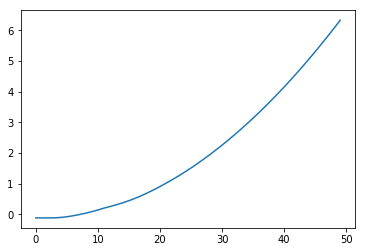

/home/pangliang/nips/venv/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


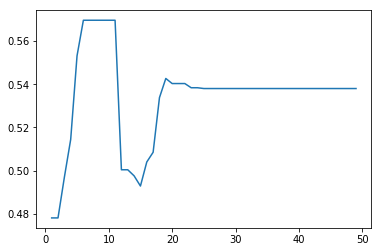

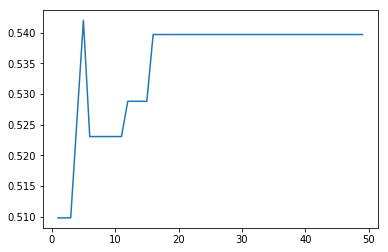

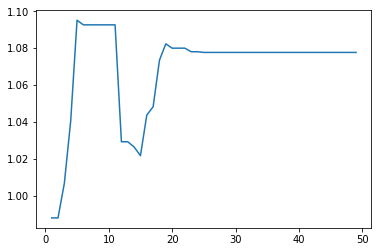

Label =  2 , Score =  [6.601853]


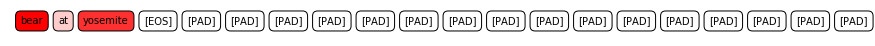

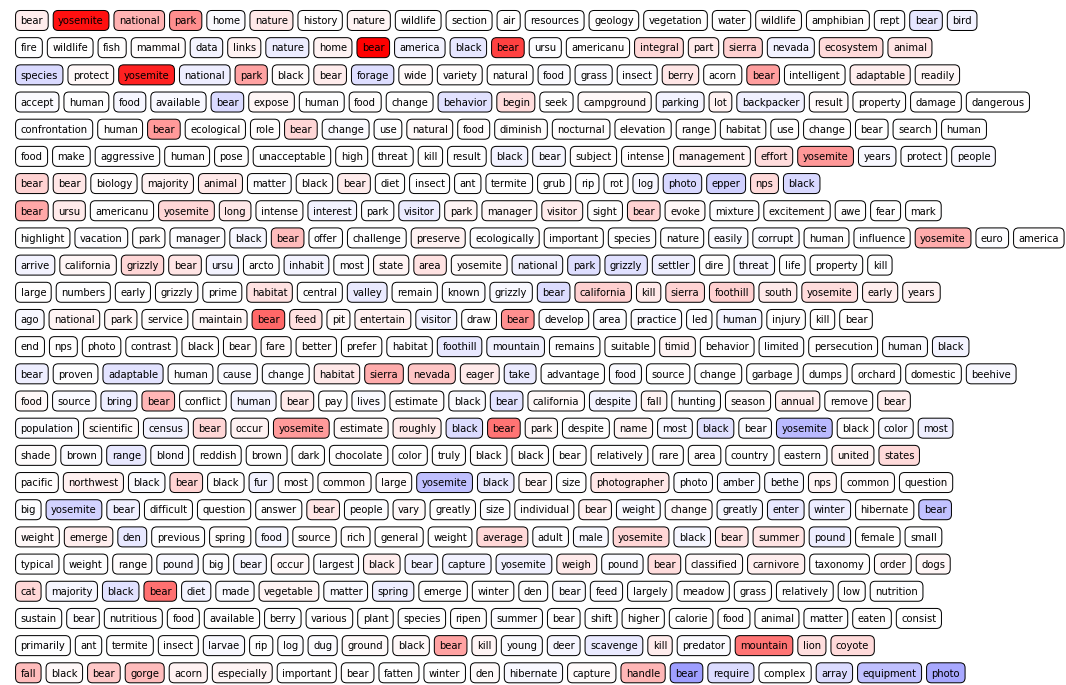

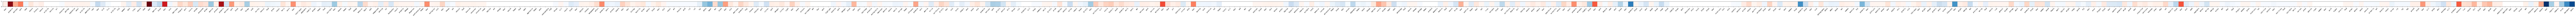

In [209]:
X1_one = X1[:1]
X1_len_one = X1_len[:1]
X2_one = X2[:1]
X2_len_one = X2_len[:1]
Y_one = Y[:1]
pathIG(X1_one, X2_one, X1_len_one, X2_len_one, config)

explain(X1_one, X2_one, X1_len_one, X2_len_one, Y_one, config)

In [160]:
def explain_grad(X1, X2, X1_len, X2_len, config):
    DPool = dynamic_pooling_index(X1_len, X2_len, config['data1_maxlen'], config['data2_maxlen'])
    I1, I2, I3 = sess.run(tf.get_collection('explain_input'), feed_dict={
        placeholders['X1']: X1,
        placeholders['X2']: X2,
        placeholders['dpool_index']: DPool
                           })
    
    grad_two = sess.run([grads1, grads2], feed_dict={
        placeholders['dpool_index']: DPool,
        tf.get_collection('explain_input')[0]: I1,
        tf.get_collection('explain_input')[1]: I2
    })

    v1 = np.sum(grad_two[0][0]*I1, axis=0)
    v1 = np.sum(I1, axis=0)
    visualize_explain(X1[0], du.word_dict, v1)
    plt.show()
    #print(np.sum(v1, axis=1))

    v2 = np.sum(grad_two[1][0]*I2, axis=0)
    v2 = np.sum(I2, axis=0)
    visualize_explain(X2[0][-30:], du.word_dict, v2[-30:])
    plt.show()
    visualize_explain(X2[0], du.word_dict, v2)
    plt.show()
    #print(np.sum(v2, axis=1)[:20])

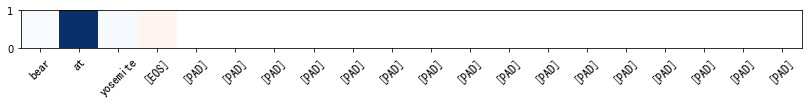

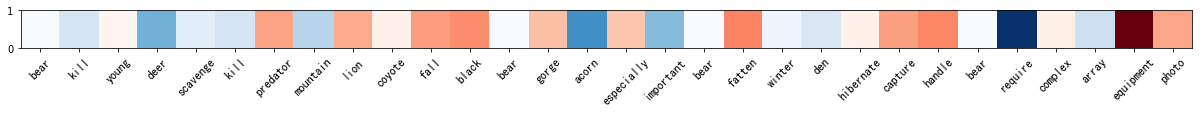

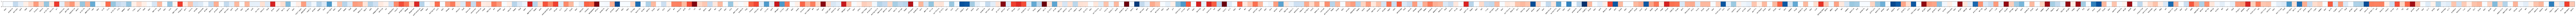

In [161]:
X1_one = X1[:1]
X1_len_one = X1_len[:1]
X2_one = X2[:1]
X2_len_one = X2_len[:1]
explain_grad(X1_one, X2_one, X1_len_one, X2_len_one, config)

Score =  [6.601853]


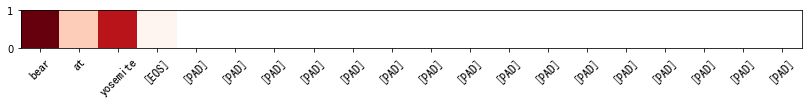

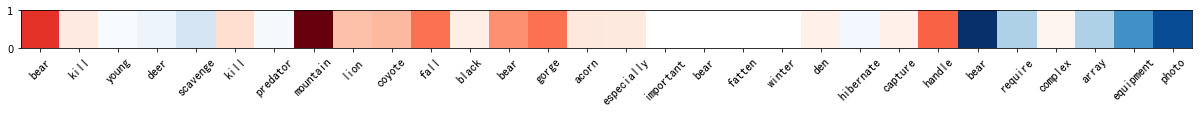

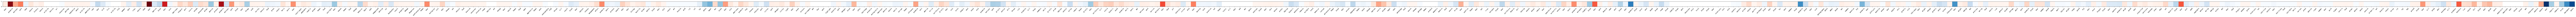

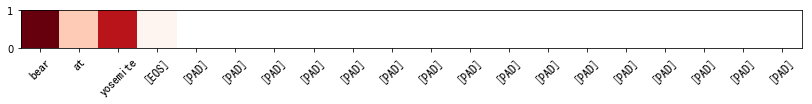

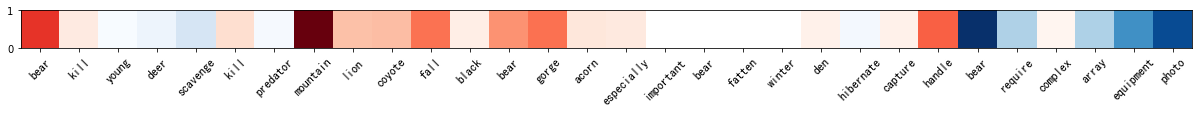

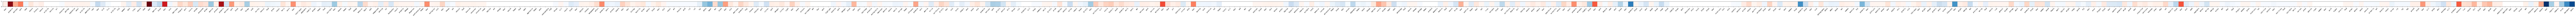

In [155]:
X1_one = X1[:1]
X1_len_one = X1_len[:1]
X2_one = X2[:1]
X2_len_one = X2_len[:1]
explain(X1_one, X2_one, X1_len_one, X2_len_one, config)

In [169]:
len(X1)

40

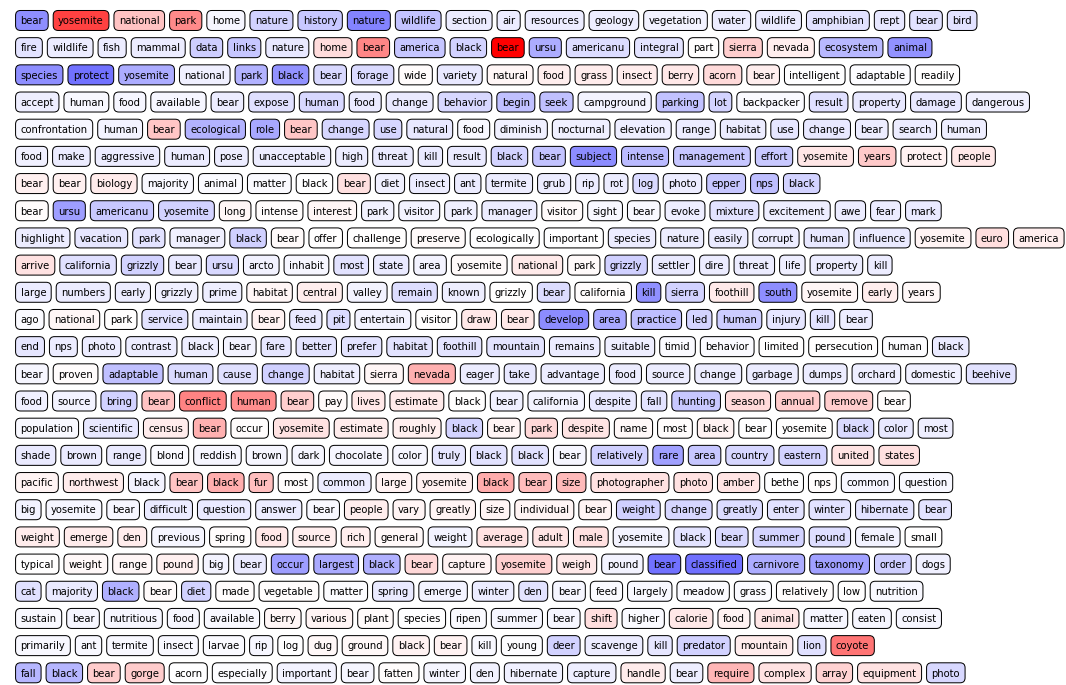

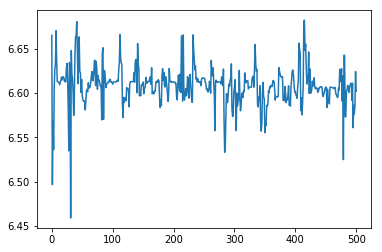

In [232]:
def forward(X1, X2, X1_len, X2_len, config):
    DPool = dynamic_pooling_index(X1_len, X2_len, config['data1_maxlen'], config['data2_maxlen'])
    
    score = sess.run(tf.get_collection('explain_output')[0], feed_dict={
        placeholders['X1']: X1,
        placeholders['X2']: X2,
        placeholders['dpool_index']: DPool
                           })
    
    v2 = -(score[:-1] - score[-1])
    plot_text_heatmap([du.word_dict[w] for w in X2[-1]], np.mean(v2,axis=-1))
    return score

X1_one = X1[0]
X1_len_one = X1_len[0]
X2_one = X2[0]
X2_len_one = X2_len[0]
X1_dup = [X1_one] * 501
X2_dup = []
for i in range(500):
    X2_new = X2_one.copy()
    #X2_new[i] = du.iword_dict['$$']
    #X2_new[i] = du._PAD_
    X2_new = X2_new[:i].tolist() + X2_new[i+1:].tolist() + [du.iword_dict['$$']]
    X2_dup.append(X2_new)
X2_dup.append(X2_one)
X1_dup = np.array(X1_dup)    
X2_dup = np.array(X2_dup)
X1_len_dup = np.array([X1_len_one] * 501)
X2_len_dup = np.array([X2_len_one] * 501)

score = forward(X1_dup, X2_dup, X1_len_dup, X2_len_dup, config)
plt.figure()
plt.plot(score)
plt.show()